In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

normalizing only works for linear homog recurrence relation.

get recurrence relation.

numerical integration gets computationally expensive bc a lot of n, alpha, x combinations

so use recurrence. know K0 analytically from integral bc simple to evaluate. 

recurrence relation is linear but not homogeneous. could maybe guess particular solution so that we can use bessel function method.

$\alpha / z$ sets critical value for when to use upwards vs downwards recurrence. set this critical value at 1/2. could reduce this number.

for downward recurrence, use power series to get Kn,max. this is expensive, but it allows us to get many others in the recurrence relation for cheap. cost is upfront. coefficients in power series are small. could use numpy integrator but with this way we can control accuracy by adding more terms. 

there is an analytic solution in terms of a power series. we can use this to check.

can also use scipy integrate to check work.

for homework, calculate n=0 to 10. and for several alpha/z

plot Ks together.

fxn of z alpha n
set epsilon for accuracy. if alpha / z ^ k < epsilon, terminate sum. 
set 1/2 for critical down/up.
if less down
    - taylor expand for KN (large N), then go down. keep going until abs value is small. xn=1 ; for m in large number (x_n / z)/(n+m+1). just a taylor series
    - then can just do downward recursion

if greater up: simple. return Kn

plot for all n from 1 to 10
compare different alpha/z values plotting might be weird bc one might be much larger than others
alpha/z = 0.1 0.2 0.3 0.5



set 1 as threshold

set z = 1 and plot kn for diff alpha values
0 - 10
check if 0.49 and 0.5 are similar with critical alpha/z = 0.5. if close shows it works wells

In [196]:
class KnSolver:
    def __init__(self, alpha, z, n_max, epsilon):
        '''
        Packages different solutions methods to Kn recurrence relation, for a given alpha and z. 
        
        Args
            alpha (float): parameter in K functions.
            z (float): parameter in K functions.
            n_max (int): maximum n for which to compute Kn.
            epsilon (float): controls when to terminate the power series to brute force calculate K0. This number should be small.
        '''
        self._alpha = alpha
        self._z = np.array(z)
        self._epsilon = epsilon
        self._n_max = n_max
        self._critical_ratio = 0.5
    
    def _calculate_K_zero_at_z(self, z):
        '''
        Calculate K0 with log definition. 
        '''
        return (1 / self._alpha) * np.log(1 + self._alpha / z)
    
    def analytically_calculate_K_zero_at_z(self, z):
        '''
        Calculate K0 with a power series. Terminate this series if the coefficient is sufficiently small, or if the number of iterations exceeds a set number. 
        '''
        k = 1
        coefficient = 1
        sum = 0
        max_iter = 100000
        while np.abs(coefficient) > self._epsilon:
            coefficient = (-self._alpha / z)**k 
            sum += coefficient / k
            
            k += 1
            
            if k > max_iter:
                print(f'Warning: exceeding {max_iter} iterations.')
                break
        
        return (-1 / self._alpha) * sum
    
    def analytic_solution_Kn_at_z(self, n, z):
        '''
        Solve for Kn, given z and alpha, using the power series solution. 
        '''
        
        sum = 0
        for k in range(1, n+1):
            coefficient = (-self._alpha / z)**k 
            sum += coefficient / k
        
        return (-z/self._alpha)**n * (self.analytically_calculate_K_zero_at_z(z) + sum / self._alpha)
    
    def upwards_recurrence_at_z(self, K0, z):
        '''
        Perform upwards recurrence for a given z and alpha. 
        
        Returns
            Kn_history (ndarray): an array of the Kn values. 
        '''
        Kn = K0
        Kn_history = np.zeros(self._n_max + 1)
        
        for n in range(self._n_max + 1):
            Kn_history[n] = Kn
            Kn = 1/(self._alpha * (n + 1)) - (z / self._alpha) * Kn
        
        return Kn_history
    
    def downwards_recurrence_at_z(self, z):
        '''
        Perform downwards recurrence for a given z and alpha. 
        
        Returns
            Kn_history (ndarray): an array of the Kn values. 
        '''
        Kn_max = self.analytic_solution_Kn_at_z(self._n_max, z)
        Kn_history = np.zeros(self._n_max + 1)
        Kn_history[-1] = Kn_max
        
        Kn = Kn_max
        for n in range(self._n_max - 1, -1, -1):
            Kn = (-self._alpha / z) * (Kn - 1/(self._alpha * (n + 1)))
            Kn_history[n] = Kn

        return Kn_history
    
    def solve_Kn_integral(self):
        '''
        Solve an integral to find Kn. 
        
        Returns
            Kn_history (ndarray): an array of the Kn values.
        '''
        def integrand(x, alpha, n):
            return x**n / (self._z + alpha * x)
        
        Kn_history = np.zeros(self._n_max + 1)
    
        for n in range(self._n_max + 1): 
            Kn_history[n] = integrate.quad(integrand, 0, 1, args=(self._alpha, n))[0]
        
        return Kn_history
    
    def taylor_approximate_Kn(self, n, z):
        '''
        Calculate Taylor series for Kn.
        '''
        coefficient = 1
        k = 0
        sum = 0
        max_iter = 100000
        while np.abs(coefficient) > self._epsilon:
            coefficient = (-self._alpha / z)**k 
            sum += coefficient / (n + k + 1)
            k += 1 
            
            if k > max_iter:
                print(f'Warning: exceeding {max_iter} iterations.')
                break
        
        return sum / z
    
    def solve_analytically_at_z(self, z):
        '''
        Solve the power series to find Kn. 
        '''
        Kn = [self.analytic_solution_Kn_at_z(n, z) for n in range(0, self._n_max+1)]
        
        return Kn
        
    
    def calculate_Kn_at_z(self, z):
        '''
        Calculate Kn using recurrence. If abs(alpha/z) < critical ratio, use downwards recurrence. Otherwise, use upwards recurrence. 
        '''
        K0 = self._calculate_K_zero_at_z(z)
        if np.abs(self._alpha / self._z) < self._critical_ratio:
            return self.downwards_recurrence_at_z(z)
                
        else:
            return self.upwards_recurrence_at_z(K0, z)

Text(0.5, 0.98, 'Solutions by Recurrence and by Integral')

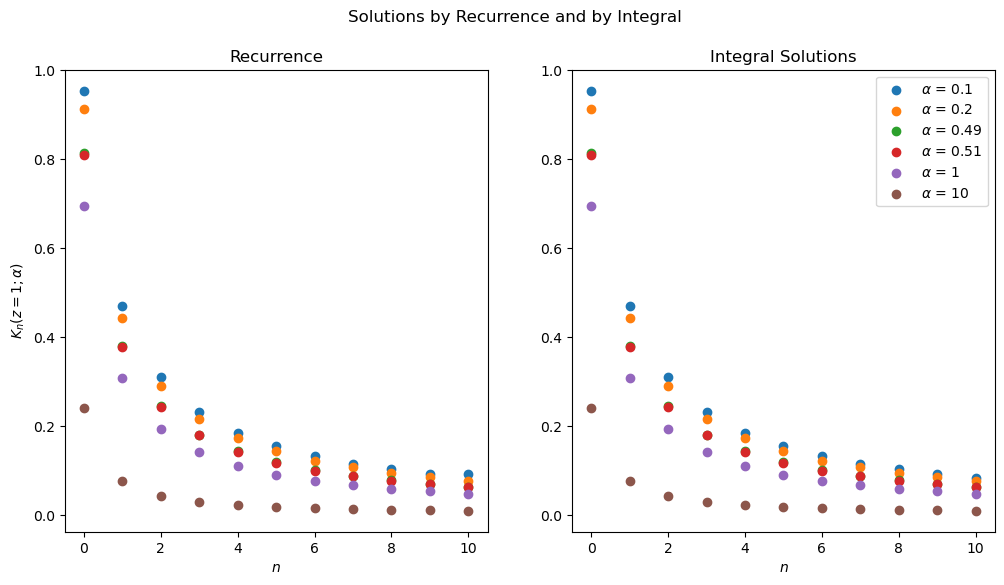

In [233]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
z = 1
alphas = [0.1, 0.2, 0.49, 0.51, 1, 10]
x_axis = [i for i in range(0, 11)]

for alpha in alphas:
    solver = KnSolver(alpha=alpha, z=[z], n_max=10, epsilon=1e-10)
    axs[0].scatter(x_axis, solver.calculate_Kn_at_z(z))
    
    axs[1].scatter(x_axis, solver.solve_Kn_integral(), label=r'$\alpha$ = '+str(alpha))

axs[1].legend()
axs[0].set_ylabel(r'$K_n(z=1; \alpha)$')
axs[0].set_xlabel(r'$n$')
axs[1].set_xlabel(r'$n$')

axs[0].set_title('Recurrence')
axs[1].set_title('Integral Solutions')

fig.suptitle('Solutions by Recurrence and by Integral')

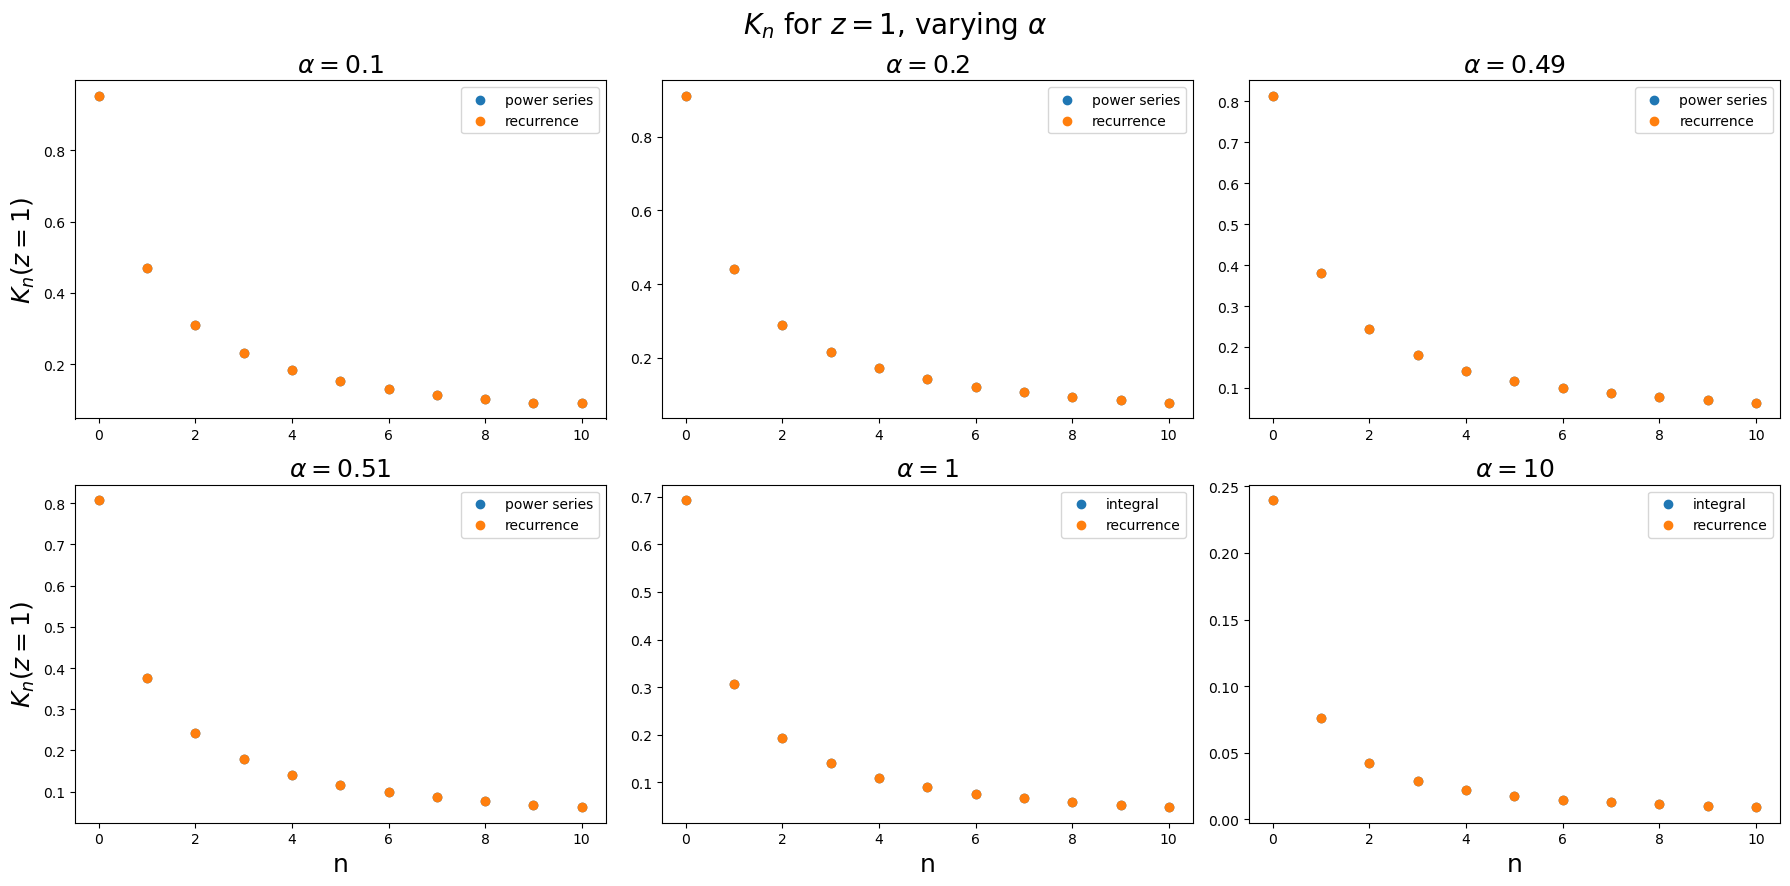

In [224]:
alphas = [0.1, 0.2, 0.49, 0.51, 1, 10]
z = 1
fig, axs = plt.subplots(2, 3, figsize=(18, 9))
x_axis = [i for i in range(0, 11)]

for alpha, ax in zip(alphas, axs.ravel()):
    solver = KnSolver(alpha=alpha, z=[z], n_max=10, epsilon=1e-10)
    if alpha/z < 1:
        ax.scatter(x_axis, solver.solve_analytically_at_z(z), label='power series')
    else:
        ax.scatter(x_axis, solver.solve_Kn_integral(), label='integral')
        
    ax.scatter(x_axis, solver.calculate_Kn_at_z(z), label='recurrence')
    
    #ax.set_yscale('log')
    ax.set_title(r'$\alpha=$' + f'{alpha}', fontsize=18)
    ax.legend()

axs[0][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_xlabel(r'n', fontsize=18)
axs[1][1].set_xlabel(r'n', fontsize=18)
axs[1][2].set_xlabel(r'n', fontsize=18)

fig.suptitle(r'$K_n$ for $z=1$, varying $\alpha$', fontsize=20)
plt.tight_layout()

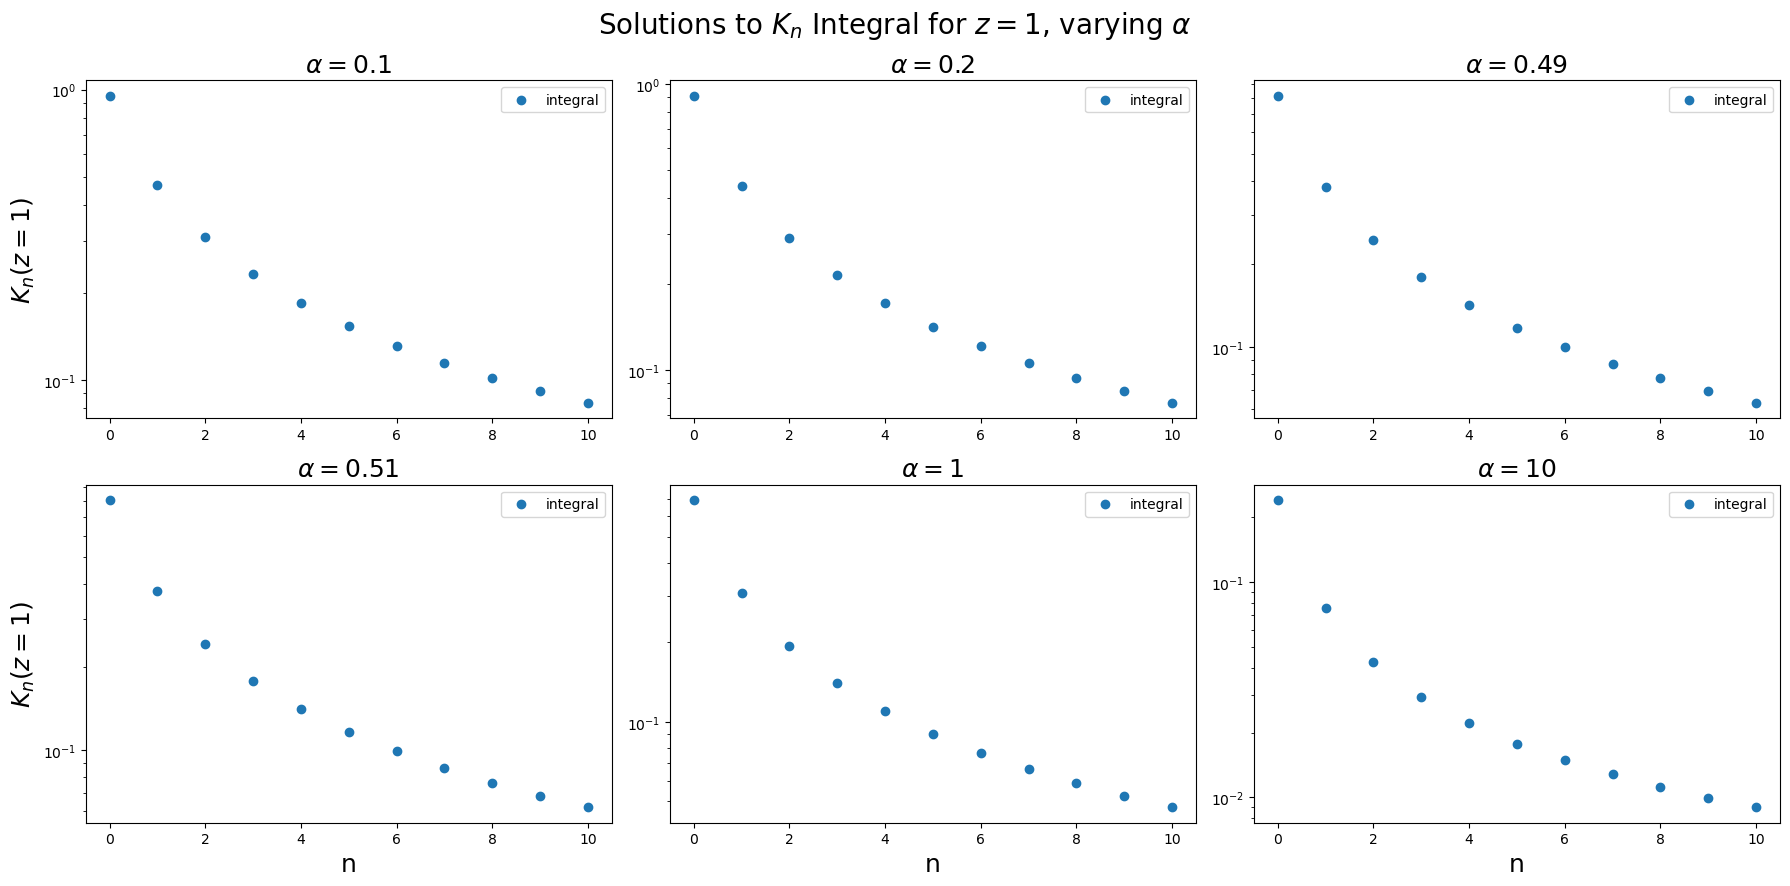

In [218]:
alphas = [0.1, 0.2, 0.49, 0.51, 1, 10]
z = 1
fig, axs = plt.subplots(2, 3, figsize=(18, 9))
x_axis = [i for i in range(0, 11)]

for alpha, ax in zip(alphas, axs.ravel()):
    solver = KnSolver(alpha=alpha, z=[z], n_max=10, epsilon=1e-10)
    
    
    ax.scatter(x_axis, solver.solve_Kn_integral(), label='integral')
    
    ax.set_yscale('log')
    ax.set_title(r'$\alpha=$' + f'{alpha}', fontsize=18)
    ax.legend()

axs[0][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_xlabel(r'n', fontsize=18)
axs[1][1].set_xlabel(r'n', fontsize=18)
axs[1][2].set_xlabel(r'n', fontsize=18)

fig.suptitle(r'Solutions to $K_n$ Integral for $z=1$, varying $\alpha$', fontsize=20)
plt.tight_layout()

OverflowError: (34, 'Result too large')

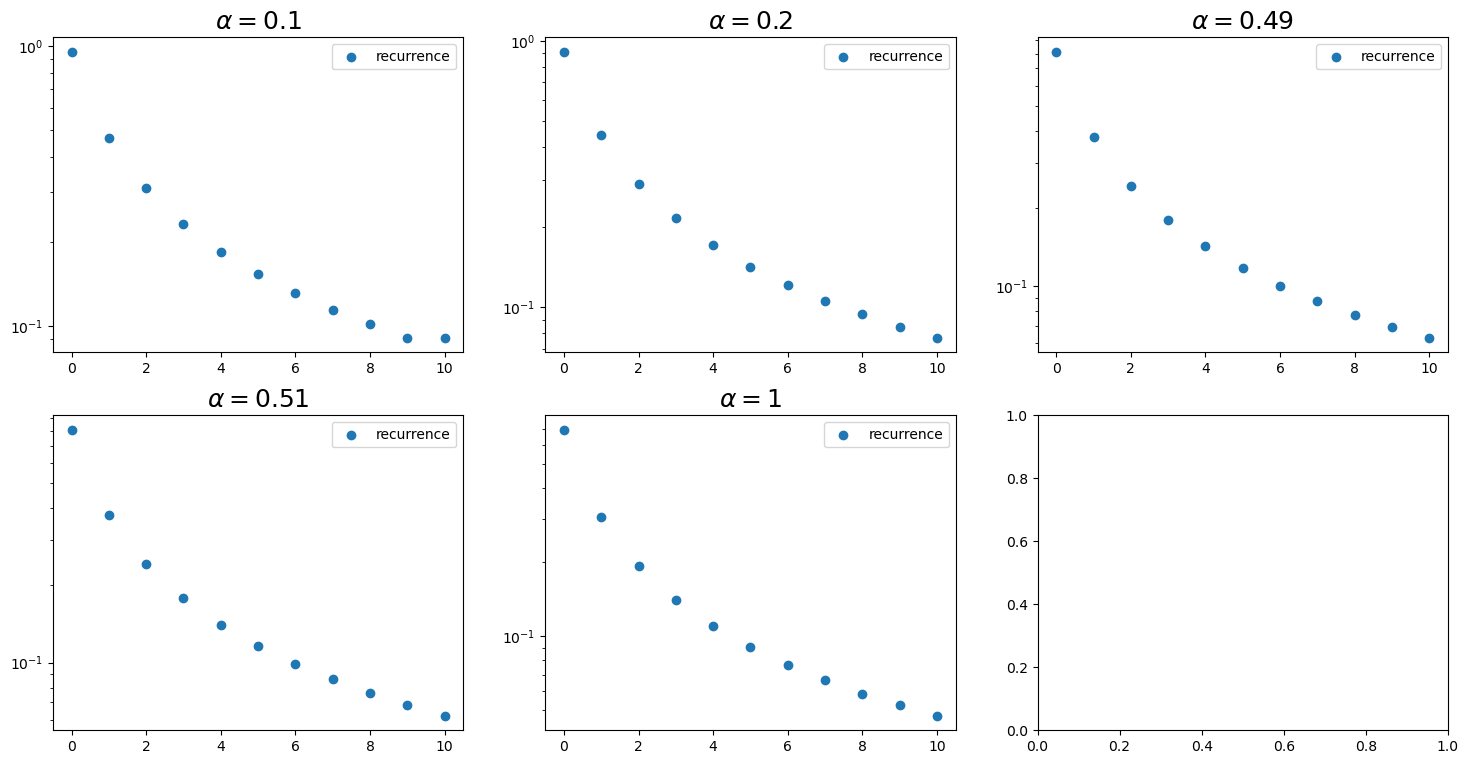

In [220]:
alphas = [0.1, 0.2, 0.49, 0.51, 1, 1.1]
z = 1
fig, axs = plt.subplots(2, 3, figsize=(18, 9))
x_axis = [i for i in range(0, 11)]

for alpha, ax in zip(alphas, axs.ravel()):
    solver = KnSolver(alpha=alpha, z=[z], n_max=10, epsilon=1e-10)
        
    K_zero = solver._calculate_K_zero_at_z(z)  
    ax.scatter(x_axis, solver.downwards_recurrence_at_z(z), label='recurrence')
    
    ax.set_yscale('log')
    ax.set_title(r'$\alpha=$' + f'{alpha}', fontsize=18)
    ax.legend()

axs[0][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_xlabel(r'n', fontsize=18)
axs[1][1].set_xlabel(r'n', fontsize=18)
axs[1][2].set_xlabel(r'n', fontsize=18)

fig.suptitle(r'$K_n$ for $z=1$, varying $\alpha$', fontsize=20)
plt.tight_layout()

OverflowError: (34, 'Result too large')

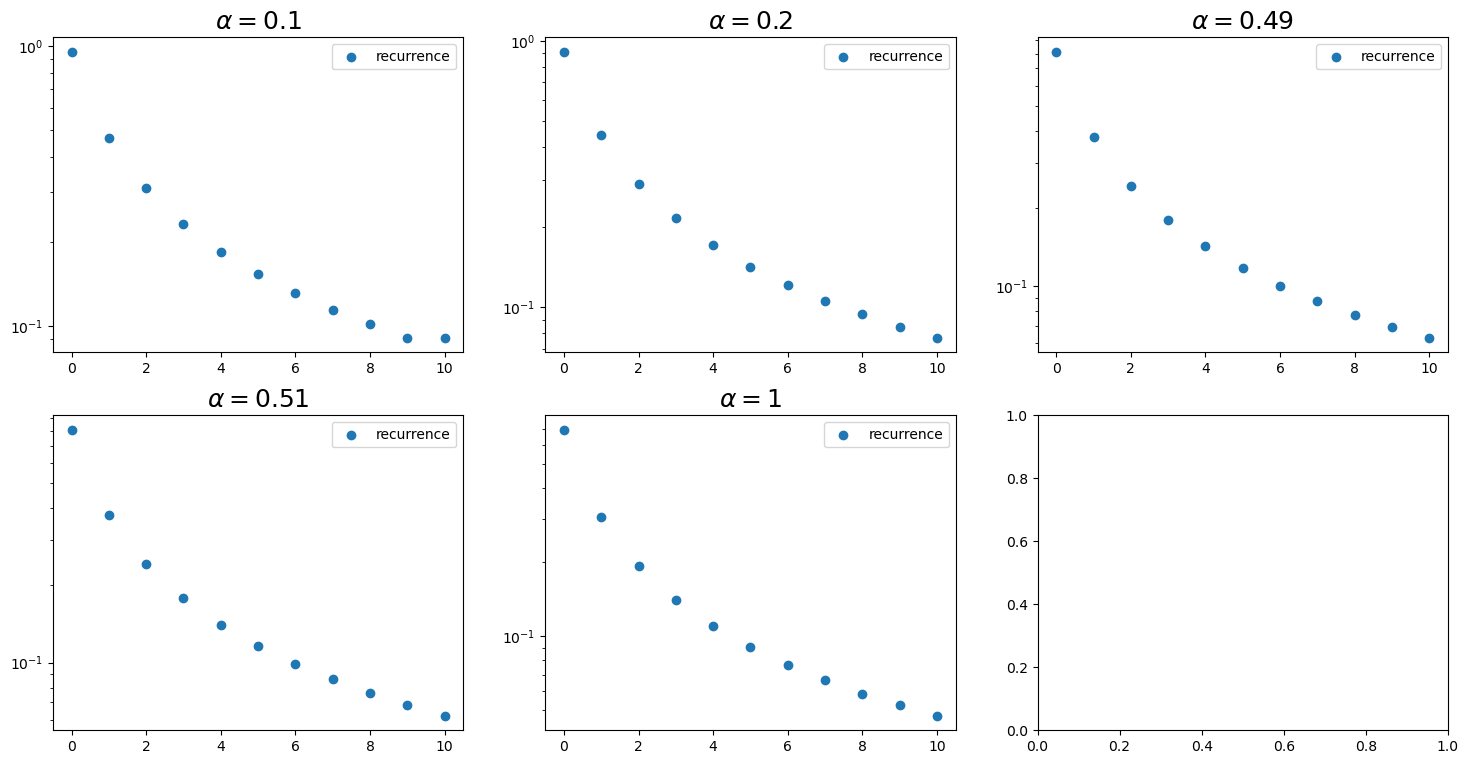

In [216]:
alphas = [0.1, 0.2, 0.49, 0.51, 1, 1.1]
z = 1
fig, axs = plt.subplots(2, 3, figsize=(18, 9))
x_axis = [i for i in range(0, 11)]

for alpha, ax in zip(alphas, axs.ravel()):
    solver = KnSolver(alpha=alpha, z=[z], n_max=10, epsilon=1e-10)
        
    K_zero = solver.analytically_calculate_K_zero_at_z(z)  
    ax.scatter(x_axis, solver.upwards_recurrence_at_z(K_zero, z), label='recurrence')
    
    ax.set_yscale('log')
    ax.set_title(r'$\alpha=$' + f'{alpha}', fontsize=18)
    ax.legend()

axs[0][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_ylabel(r'$K_n(z=1)$', fontsize=18)
axs[1][0].set_xlabel(r'n', fontsize=18)
axs[1][1].set_xlabel(r'n', fontsize=18)
axs[1][2].set_xlabel(r'n', fontsize=18)

fig.suptitle(r'$K_n$ for $z=1$, varying $\alpha$', fontsize=20)
plt.tight_layout()

try with generators https://realpython.com/introduction-to-python-generators/